# Home work exercises day 2 - Bryn Lampe

In [ ]:
!pip install --upgrade quantecon

import numpy as np
from itertools import product
from scipy.optimize import brentq
from numba import prange
from numba import njit
from scipy.special import factorial2
import matplotlib.pyplot as plt
%matplotlib inline

# Writing good code

### Exercise 1

Here is some code that needs improving.

It involves a basic supply and demand problem.

Supply is given by

$$
q_s(p) = \exp(\alpha p) - \beta.
$$

The demand curve is

$$
q_d(p) = \gamma p^{-\delta}.
$$

The values $ \alpha $, $ \beta $, $ \gamma $ and
$ \delta $ are **parameters**

The equilibrium $ p^* $ is the price such that
$ q_d(p) = q_s(p) $.

We can solve for this equilibrium using a root finding algorithm.
Specifically, we will find the $ p $ such that $ h(p) = 0 $,
where

$$
h(p) := q_d(p) - q_s(p)
$$

This yields the equilibrium price $ p^* $. From this we get the
equilibrium price by $ q^* = q_s(p^*) $

The parameter values will be

- $ \alpha = 0.1 $  
- $ \beta = 1 $  
- $ \gamma = 1 $  
- $ \delta = 1 $ 

[2.9334108855347023, 0.3409000781074418]
[[1.         1.         0.1        1.         2.93341089 0.34090008]
 [1.         1.         0.1        1.1        3.35247792 0.29828683]
 [1.         1.         0.1        1.2        3.80405366 0.26287747]]


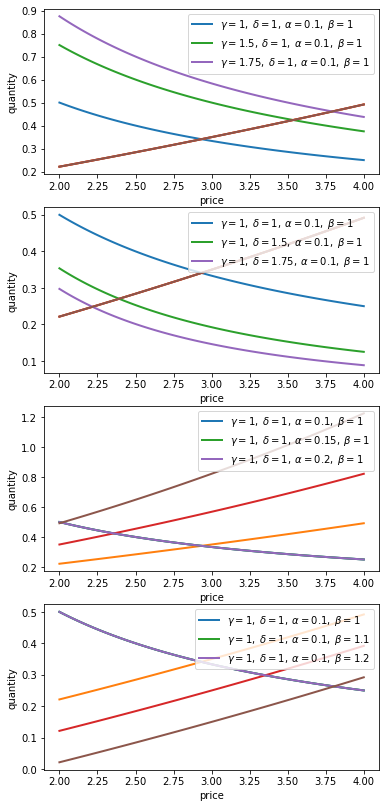

In [136]:

def equilibrium_price(γi, δi, αi, βi):   
    '''
    This functions finds the equilibrium price and
    quantity for given parameters.

    '''
    def h(p):
        return γi * p**(-δi) - (np.exp(αi * p) - βi)

    p_star = brentq(h, 2, 4)
    q_star = γi * p_star**(-δi)
    
    return [p_star, q_star]

print(equilibrium_price(1,1,0.1,1))

def price_points(ax, γs, δs, αs, βs):
    '''
    This functions finds the equilibrium and plots the supply and demand functions.
    '''
    
    counter = 0
    returned_equilibrium = [0]*len(list(product(γs, δs, αs, βs)))
    
    for (γi, δi, αi, βi) in product(γs, δs, αs, βs):
        
        def h(p):
            return γi * p**(-δi) - (np.exp(αi * p) - βi)
    
        p_star = brentq(h, 2, 4)
        q_star = γi * p_star**(-δi)
        
        returned_equilibrium[counter] = [γi, δi, αi, βi, p_star, q_star]
        counter += 1
        
        p_grid = np.linspace(2, 4, 100)

        qs = np.exp(αi * p_grid) - βi
        qd = γi * p_grid**(-δi)

        ax.plot(p_grid, qd, '-', lw=2, label=rf"$\gamma = {γi},\; \delta = {δi},\; \alpha = {αi},\; \beta = {βi}$")
        ax.plot(p_grid, qs, '-', lw=2)
        
    ax.set_xlabel('price')
    ax.set_ylabel('quantity')
    ax.legend(loc='upper right')
    
    returned_equilibrium = np.array(returned_equilibrium)
    #returned_equilibrium.shape() = (6,counter)
    return returned_equilibrium 
    

fig, axes = plt.subplots(4, 1, figsize=(6, 14))

# Parameters (γs, δs, αs, βs)
set_one = ([1, 1.5, 1.75], [1], [0.1], [1])
set_two = ([1], [1, 1.5, 1.75], [0.1], [1])
set_three = ([1], [1], [0.1, 0.15, 0.2,], [1])
set_four = ([1], [1],  [0.1], [1, 1.1, 1.2])


for (ax, params) in zip(axes, (set_one, set_two, set_three, set_four)):
    γs, δs, αs, βs = params
    equilibrium = price_points(ax, γs, δs, αs, βs)

print(equilibrium)



# Parallelization

### Exercise 1

In [an earlier exercise](numba.ipynb#speed-ex1), we used Numba to accelerate an
effort to compute the constant $ \pi $ by Monte Carlo.

Now try adding parallelization and see if you get further speed gains.

You should not expect huge gains here because, while there are many
independent tasks (draw point and test if in circle), each one has low
execution time.

Generally speaking, parallelization is less effective when the individual
tasks to be parallelized are very small relative to total execution time.

This is due to overheads associated with spreading all of these small tasks across multiple CPUs.

Nevertheless, with suitable hardware, it is possible to get nontrivial speed gains in this exercise.

For the size of the Monte Carlo simulation, use something substantial, such as
`n = 100_000_000`.

In [137]:
count = 0

@njit(parallel=True)
def approx_pi(n):
    count = 0
    for i in prange(n):
        u, v = np.random.uniform(0, 1), np.random.uniform(0, 1)
        d = np.sqrt((u - 0.5)**2 + (v - 0.5)**2)
        if d < 0.5:
            count += 1
    return count/n * 4

%time approx_pi(100000000)

CPU times: user 3.57 s, sys: 8.3 ms, total: 3.58 s
Wall time: 760 ms


3.14155352

# Heavy-Tailed Distributions


<a id='index-0'></a>

### Exercise 1

Replicate [the figure presented above](#light-heavy-fig1) that compares normal and Cauchy draws.

Use `np.random.seed(11)` to set the seed.

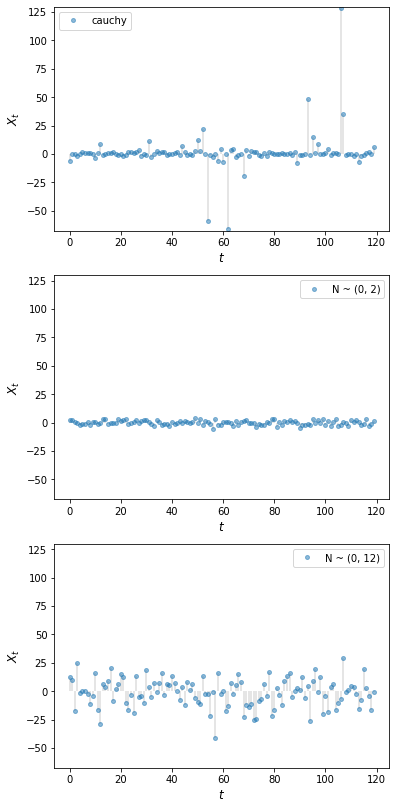

In [39]:
np.random.seed(11)

x = range(120)

cauchy = np.random.standard_cauchy(120)
normal = np.random.normal(0,2,120)
normal2 = np.random.normal(0,12,120)

y_max = np.max((cauchy, normal, normal2))
y_min = np.min((cauchy, normal, normal2))

fig, axes = plt.subplots(3, 1, figsize=(6, 14))

plots = (cauchy,normal,normal2)
legends = ('cauchy','N ~ (0, 2)', 'N ~ (0, 12)')

for (ax, plot, legend) in zip(axes, plots, legends):
    ax.plot(x, plot , label=legend, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(x, 0, plot, lw=0.2)
    ax.set(ylim=(y_min-1,y_max+1))
    ax.legend()
    ax.set_ylabel('$X_t$', fontsize=12)
    ax.set_xlabel('$t$', fontsize=12)

plt.show()

### Exercise 3

Repeat exercise 1, but replace the three distributions (two normal, one
Cauchy) with three Pareto distributions using different choices of
$ \alpha $.

For $ \alpha $, try 1.15, 1.5 and 1.75.

Use `np.random.seed(11)` to set the seed.

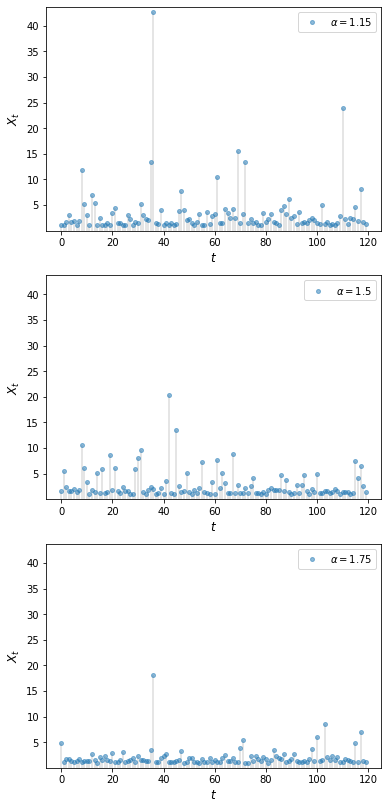

In [40]:
np.random.seed(11)

a1, a2, a3, x_bar = 1.15,1.5,1.75, 1  # shape and mode

pareto1 = (np.random.pareto(a1, 120) + 1) * x_bar
pareto2 = (np.random.pareto(a2, 120) + 1) * x_bar
pareto3 = (np.random.pareto(a3, 120) + 1) * x_bar

y_max = np.max((pareto1, pareto2, pareto3))
y_min = np.min((pareto1, pareto2, pareto3))

plots = (pareto1, pareto2, pareto3)
legends = ('$\\alpha = 1.15$','$\\alpha = 1.5$', '$\\alpha = 1.75$')

x = range(120)

fig, axes = plt.subplots(3, 1, figsize=(6, 14))

counter = 0

for (ax, plot, legend) in zip(axes, plots, legends):
    ax.plot(x, plot, label=legend, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.vlines(x, 0, plot, lw=0.2)
    ax.set(ylim=(y_min-1,y_max+1))
    ax.legend()
    ax.set_ylabel('$X_t$', fontsize=12)
    ax.set_xlabel('$t$', fontsize=12)

plt.show()

### Exercise 4

Replicate the rank-size plot figure [presented above](#rank-size-fig1).

Use `np.random.seed(13)` to set the seed.

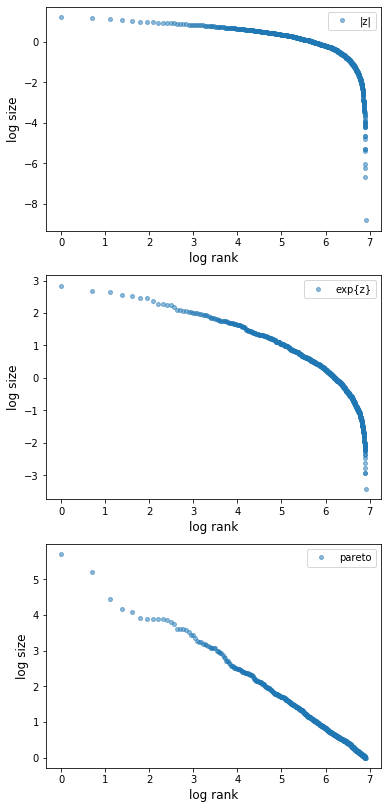

In [41]:
np.random.seed(13)

a, x_bar = 1.15, 1

x = np.log(range(1,1001,1))

normal = np.absolute(np.random.normal(0,1,1000))
log_normal = np.exp(np.random.normal(0,1,1000))
pareto = (np.random.pareto(a, 1000) + 1) * x_bar

normal = np.log(np.sort(normal)[::-1])
log_normal = np.log(np.sort(log_normal)[::-1])
pareto = np.log(np.sort(pareto)[::-1])

plots = (normal, log_normal, pareto)
legends = ('|z|','exp{z}', 'pareto')

fig, axes = plt.subplots(3, 1, figsize=(6, 14))

counter = 0

for (ax, plot, legend) in zip(axes, plots, legends):
    ax.plot(x, plot, label=legend, linestyle='', marker='o', alpha=0.5, ms=4)
    ax.legend()
    ax.set_ylabel('log size', fontsize=12)
    ax.set_xlabel('log rank', fontsize=12)

plt.show()

### Exercise 5

There is an ongoing argument about whether the firm size distribution should
be modeled as a Pareto distribution or a lognormal distribution (see, e.g.,
[[FDGA+04]](zreferences.ipynb#fujiwara2004pareto), [[KLS18]](zreferences.ipynb#kondo2018us) or [[ST19]](zreferences.ipynb#schluter2019size)).

This sounds esoteric but has real implications for a variety of economic
phenomena.

To illustrate this fact in a simple way, let us consider an economy with
100,000 firms, an interest rate of `r = 0.05` and a corporate tax rate of
15%.

Your task is to estimate the present discounted value of projected corporate
tax revenue over the next 10 years.

Because we are forecasting, we need a model.

We will suppose that

1. the number of firms and the firm size distribution (measured in profits) remain fixed and  
1. the firm size distribution is either lognormal or Pareto.  


Present discounted value of tax revenue will be estimated by

1. generating 100,000 draws of firm profit from the firm size distribution,  
1. multiplying by the tax rate, and  
1. summing the results with discounting to obtain present value.  


The Pareto distribution is assumed to take the form [(5)](#equation-pareto) with $ \bar x = 1 $ and $ \alpha = 1.05 $.

(The value the tail index $ \alpha $ is plausible given the data [[Gab16]](zreferences.ipynb#gabaix2016power).)

To make the lognormal option as similar as possible to the Pareto option, choose its parameters such that the mean and median of both distributions are the same.

Note that, for each distribution, your estimate of tax revenue will be random because it is based on a finite number of draws.

To take this into account, generate 100 replications (evaluations of tax revenue) for each of the two distributions and compare the two samples by

- producing a [violin plot](https://en.wikipedia.org/wiki/Violin_plot) visualizing the two samples side-by-side and  
- printing the mean and standard deviation of both samples.  


For the seed use `np.random.seed(1234)`.

What differences do you observe?

(Note: a better approach to this problem would be to model firm dynamics and
try to track individual firms given the current distribution.  We will discuss
firm dynamics in later lectures.)

mean and standard deviation of pareto draws: [10227824.808320213, 11923138.621221175]
mean and standard deviation of pareto draws: [8398464.654266955, 60700.730148047456]


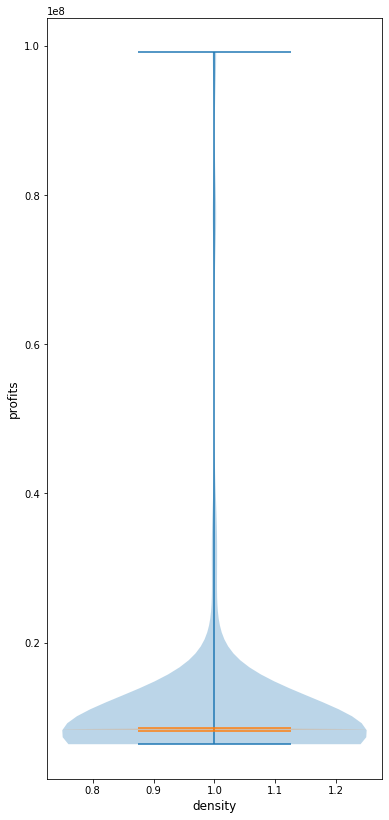

In [46]:
np.random.seed(1234)

a, x_bar = 1.05, 1
tax_rate = 0.15
r = 0.05

μ = 0.5
σ = 2



@njit(parallel=True)
def profit_function(years,firms,replications,a = 1.05, x_bar = 1, r = 0.05, tax_rate = 0.15, μ = 0.5, σ = 2):
    
    yearly_net_profits_pareto = np.zeros(years)
    yearly_net_profits_lognormal = np.zeros(years)

    total_net_profits_pareto = np.zeros(replications)
    total_net_profits_lognormal = np.zeros(replications)
    
    for i in prange(replications):
        for t in prange(years):
            
            '''
            the following assumes that profits realied in at the start of the current period rather
            than at the end, therefore the first period profits do not need to be discounted (and so
            1/(1+r) is raised to the power 0, ie use (1+r)**(-t) not (1+r)**(-t+1)) 
            '''
            net_profits_pareto = (np.random.pareto(a, firms) + 1) * x_bar * (1-tax_rate) * (1+r)**(-t) 
            net_profits_lognormal = np.exp(np.random.normal(μ,σ,firms)) * (1-tax_rate) * (1+r)**(-t) 
    
            yearly_net_profits_pareto[t] = net_profits_pareto.sum()
            yearly_net_profits_lognormal[t] = net_profits_lognormal.sum()

        total_net_profits_pareto[i] = yearly_net_profits_pareto.sum()
        total_net_profits_lognormal[i] = yearly_net_profits_lognormal.sum()
        
    return [total_net_profits_pareto, total_net_profits_lognormal]
    

profits = profit_function(10,100000,100)

pareto = [profits[0].mean(), profits[0].std()]
lognorm = [profits[1].mean(), profits[1].std()]

print(f'mean and standard deviation of pareto draws: {pareto}')
print(f'mean and standard deviation of pareto draws: {lognorm}')


fig, ax = plt.subplots(1, 1, figsize=(6, 14))
ax.violinplot(profits[0])
ax.violinplot(profits[1])
ax.set_ylabel("profits", fontsize=12)
ax.set_xlabel('density', fontsize=12)

plt.show()

# Dynamics in One Dimension

### Exercise 1

Consider again the linear model $ x_{t+1} = a x_t + b $ with $ a
\not=1 $.

The unique steady state is $ b / (1 - a) $.

The steady state is globally stable if $ |a| < 1 $.

Try to illustrate this graphically by looking at a range of initial conditions.

What differences do you notice in the cases $ a \in (-1, 0) $ and $ a
\in (0, 1) $?

Use $ a=0.5 $ and then $ a=-0.5 $ and study the trajectories

Set $ b=1 $ throughout.

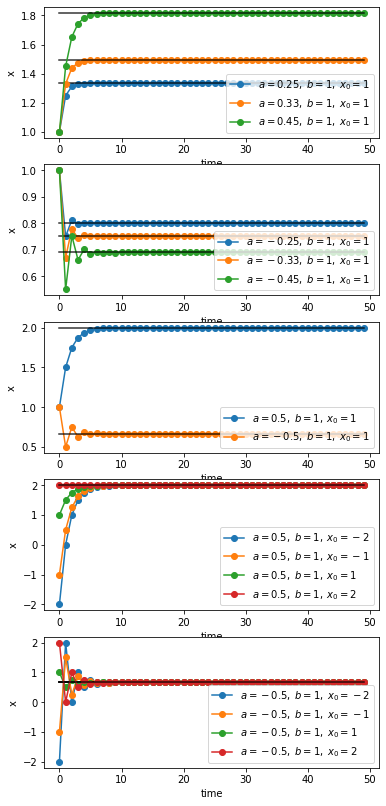

In [139]:
timeseries_length = 50
x = np.ones(timeseries_length)


def plot_path(ax, x_zeros, a_vals, b_vals, series_length=50):
    """
    Add a time series plot to the axes ax for all given parameters.
    """
    x = np.empty(series_length)

    for (x_zeroi, ai, bi) in product(x_zeros, a_vals, b_vals):
        
        x[0] = x_zeroi
        
        steady_state = np.ones(series_length)*bi/(1-ai)
        
        for t in range(series_length-1):
            x[t+1] = ai * x[t] + bi

        ax.plot(x, 'o-', label=rf"$a = {ai},\; b = {bi},\; x_0 = {x_zeroi}$")
        ax.plot(steady_state, 'k-', alpha=0.8)

    ax.set_xlabel('time')
    ax.set_ylabel('x')
    ax.legend(loc='lower right', frameon=True)

fig, axes = plt.subplots(5, 1, figsize=(6, 14))

# Parameters (x_zeros, a_vals, b_vals)
set_one = ([1], [0.25, 0.33, 0.45], [1])
set_two = ([1], [-0.25, -0.33, -0.45], [1])
set_three = ([1], [0.5,-0.5], [1])
set_four = ([-2,-1,1,2], [0.5], [1])
set_five = ([-2,-1,1,2], [-0.5], [1])

for (ax, params) in zip(axes, (set_one, set_two, set_three, set_four,set_five )):
    x_zeros, a_vals, b_vals = params
    plot_path(ax, x_zeros, a_vals, b_vals)

plt.show()

# AR1 Processes¶

### Exercise 1

Let $ k $ be a natural number.

The $ k $-th central moment of a  random variable is defined as

$$
M_k := \mathbb E [ (X - \mathbb E X )^k ]
$$

When that random variable is $ N(\mu, \sigma^2) $, it is know that

$$
M_k =
\begin{cases}
    0 & \text{ if } k \text{ is odd} \\
    \sigma^k (k-1)!! & \text{ if } k \text{ is even}
\end{cases}
$$

Here $ n!! $ is the double factorial.

According to [(6)](#equation-ar1-ergo), we should have, for any $ k \in \mathbb N $,

$$
\frac{1}{m} \sum_{t = 1}^m
    (X_t - \mu^* )^k
    \approx M_k
$$

when $ m $ is large.

Confirm this by simulation at a range of $ k $ using the default parameters from the lecture.


In [81]:
timeseries_length = 1000
number_simulations = 10
number_moments = 10

a, b, c = 0.9, 0.1, 0.5

mu_star = b/(1-a)
v_star = c**2/(1 - a**2)

M_k = np.empty((number_moments))
m_k = np.empty((number_moments))

m_k_sim = np.empty((number_simulations))
x_vec = np.empty(timeseries_length)

for k in range(number_moments):
    M_k[k] = v_star**(k+1) * factorial2(k, exact=True)
    
    for i in range(number_simulations):
        
        w_vec = np.random.normal(0,1,timeseries_length)
        x_vec[0] = 1
        
        for t in range(timeseries_length-1):
            x_vec[t+1] = a * x_vec[t] + b + c * w_vec[t+1]

        x_brackets = x_vec - mu_star
        x_brackets = x_brackets**(k+1)
        m_k_sim[i] = (1/timeseries_length) * x_brackets.sum()
        
        m_k_sim = np.empty((number_simulations))
        w_vec = np.empty(timeseries_length)
        x_vec = np.empty(timeseries_length)
        x_brackets = np.empty(timeseries_length)
        
    m_k[k] = m_k_sim.mean()
    
M_k[::2] = 0

print(M_k)
print(m_k)


[0.00000000e+00 1.73130194e+00 0.00000000e+00 8.99221921e+00
 0.00000000e+00 7.78412328e+01 0.00000000e+00 9.43366741e+02
 0.00000000e+00 1.46992740e+04]
[ 230.47314004  231.17563408  230.51573974  233.24858236  231.08350925
  246.03278857  224.91311667  404.58096625  322.4186051  1940.70487032]


### Exercise 2

Write your own version of a one dimensional [kernel density
estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation),
which estimates a density from a sample.

Write it as a class that takes the data $ X $ and bandwidth
$ h $ when initialized and provides a method $ f $ such that

$$
f(x) = \frac{1}{hn} \sum_{i=1}^n
K \left( \frac{x-X_i}{h} \right)
$$

For $ K $ use the Gaussian kernel ($ K $ is the standard normal
density).

Write the class so that the bandwidth defaults to Silverman’s rule (see
the “rule of thumb” discussion on [this
page](https://en.wikipedia.org/wiki/Kernel_density_estimation)). Test
the class you have written by going through the steps

1. simulate data $ X_1, \ldots, X_n $ from distribution $ \phi $  
1. plot the kernel density estimate over a suitable range  
1. plot the density of $ \phi $ on the same figure  


for distributions $ \phi $ of the following types

- [beta
  distribution](https://en.wikipedia.org/wiki/Beta_distribution)
  with $ \alpha = \beta = 2 $  
- [beta
  distribution](https://en.wikipedia.org/wiki/Beta_distribution)
  with $ \alpha = 2 $ and $ \beta = 5 $  
- [beta
  distribution](https://en.wikipedia.org/wiki/Beta_distribution)
  with $ \alpha = \beta = 0.5 $  


Use $ n=500 $.

Make a comment on your results. (Do you think this is a good estimator
of these distributions?)

### Exercise 3

In the lecture we discussed the following fact: For the $ AR(1) $ process

$$
X_{t+1} = a X_t + b + c W_{t+1}
$$

with $ \{ W_t \} $ iid and standard normal,

$$
\psi_t = N(\mu, s^2) \implies \psi_{t+1}
= N(a \mu + b, a^2 s^2 + c^2)
$$

Confirm this, at least approximately, by simulation. Let

- $ a = 0.9 $  
- $ b = 0.0 $  
- $ c = 0.1 $  
- $ \mu = -3 $  
- $ s = 0.2 $  


First, plot $ \psi_t $ and $ \psi_{t+1} $ using the true
distributions described above.

Second, plot $ \psi_{t+1} $ on the same figure (in a different
color) as follows:

1. Generate $ n $ draws of $ X_t $ from the $ N(\mu, s^2) $
  distribution  
1. Update them all using the rule
  $ X_{t+1} = a X_t + b + c W_{t+1} $  
1. Use the resulting sample of $ X_{t+1} $ values to produce a
  density estimate via kernel density estimation.  


Try this for $ n=2000 $ and confirm that the
simulation based estimate of $ \psi_{t+1} $ does converge to the
theoretical distribution.